vision encoder : full tuning  
aligner : full tuning  
llm : lora tuning  

In [ ]:
!pip install -q -U datasets einops transformers autoawq peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, CLIPTextModel, CLIPVisionModel
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image
import bitsandbytes as bnb

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Configs

In [ ]:
IMAGE_SIZE = (224, 224)
N_PATCHES_PER_IMAGE = 50#(IMAGE_SIZE[0] // vision_encoder.config.patch_size) * (IMAGE_SIZE[1] // vision_encoder.config.patch_size)
# N_COMPRESSED_PATCHES_PER_IMAGE = 10
N_COMPRESSED_PATCHES_PER_IMAGE = 50

IMAGE_TOKEN = '<|imagetoken|>'
BOI_TOKEN = '<|boi|>'  # begining of image token
EOI_TOKEN = '<|eoi|>'  # end of image token
# CLS_TOKEN = '<|cls|>'

TEXT_PADDING_MAX_LENGTH = 80 + 150 + N_COMPRESSED_PATCHES_PER_IMAGE

N_EPOCHS = 40
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 4#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = True
AMP_DTYPE = torch.bfloat16

dtype = torch.float32#torch.bfloat16
llm_dtype = torch.bfloat16

TRAIN_VISION_ENCODER = True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load LLM Model and Tokenizer

In [ ]:
if device == 'cuda':
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ")
    # llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ", torch_dtype=llm_dtype).to(device).eval()
else:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
    # llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype=llm_dtype).to(device).eval()

In [ ]:
# _ = llm_model.requires_grad_(False)

In [ ]:
tokenizer.add_tokens([IMAGE_TOKEN, BOI_TOKEN, EOI_TOKEN], special_tokens=True)

3

In [ ]:
IMAGE_TOKEN_ID = tokenizer.convert_tokens_to_ids(IMAGE_TOKEN)

In [ ]:
tokenizer

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2.5-0.5B-Instruct-AWQ', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=Fa

## Load Vision Encoder Model

In [ ]:
vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device).eval()

In [ ]:
_ = vision_encoder.requires_grad_(False)

## Prepare Dataset

In [ ]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list], cache_dir='./cache_data')['train']

In [ ]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [ ]:
hf_dataset_sampled

Dataset({
    features: ['jpg', 'json', '__key__', '__url__'],
    num_rows: 1000
})

In [ ]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMAGE_SIZE, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
# tokenizer.encode('<|im_start|>assistant')

In [ ]:
@torch.inference_mode()
def tokenize_text(texts, tokenizer=tokenizer, ignore_label = -100, generation_mode = False):
    non_prediction_target_text = f'<|vision_start|>{N_COMPRESSED_PATCHES_PER_IMAGE * IMAGE_TOKEN}<|vision_end|> describe the text'
    # end_of_non_prediction_target_token = tokenizer.encode(non_prediction_target_text)[-1]
    end_of_non_prediction_target_token = tokenizer.encode('<|im_start|>assistant')[-1]
    conversation_text_list = []
    for text in texts:
        if not generation_mode:
            conversations = [
                {'content': non_prediction_target_text, 'role': 'user'},
                {'content': text, 'role': 'assistant'},
            ]
            conversation_text = tokenizer.apply_chat_template(
                conversations, tokenize=False
            )
        else:
            conversations = [
                {'content': non_prediction_target_text, 'role': 'user'},
            ]
            conversation_text = tokenizer.apply_chat_template(
                conversations, tokenize=False, add_generation_prompt=True,
            )
        conversation_text_list.append(conversation_text)

    if not generation_mode:
        inputs = tokenizer(conversation_text_list, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    else:
        inputs = tokenizer(conversation_text_list, return_tensors='pt')
    inputs['loss_target_pos_mask'] = torch.zeros_like(inputs['input_ids'])
    loss_target_start_idx = (inputs['input_ids'] == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1
    # print(loss_target_start_idx)
    assert (loss_target_start_idx == loss_target_start_idx[0]).all()
    loss_target_start_idx = loss_target_start_idx[0]
    inputs['loss_target_pos_mask'][torch.arange(inputs['loss_target_pos_mask'].shape[0]), loss_target_start_idx:] = 1
    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs

def preprocess_data(examples, vision_encoder=vision_encoder):
    # print('preprocess_data')
    images = [image.convert("RGB") for image in examples['jpg']]
    images = [image_transforms(image) for image in images]
    image_embs = vision_encoder(torch.stack(images).to(device)).last_hidden_state

    examples["pixel_values"] = images
    examples["image_embs"] = image_embs
    tokenized_inputs = tokenize_text([d['prompt'] for d in examples['json']])
    examples["input_ids"] = tokenized_inputs['input_ids']
    examples["attention_mask"] = tokenized_inputs['attention_mask']
    examples["loss_target_pos_mask"] = tokenized_inputs['loss_target_pos_mask']

    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    image_embs = torch.stack([example["image_embs"] for example in examples])
    input_ids = torch.stack([example["input_ids"] for example in examples])
    attention_mask = torch.stack([example["attention_mask"] for example in examples])
    loss_target_pos_mask = torch.stack([example["loss_target_pos_mask"] for example in examples])

    return {
        "pixel_values": pixel_values,
        'image_embs': image_embs,
        "input_ids": input_ids,
        'attention_mask': attention_mask,
        'loss_target_pos_mask': loss_target_pos_mask,
    }

In [ ]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 2.92 s, sys: 968 ms, total: 3.88 s
Wall time: 5.4 s


In [ ]:
_d = hf_dataset_sampled[0]

In [ ]:
_d.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'pixel_values', 'image_embs', 'input_ids', 'attention_mask', 'loss_target_pos_mask'])

In [ ]:
tokenizer.decode(_d['input_ids'])

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|vision_end|> describe the text<|im_end|>\n<|im_start|>assistant\nA group of people is gathered under a large tree with green leaves. In the center, a man is wearin

In [ ]:
tokenizer.decode(_d['input_ids'] * _d['loss_target_pos_mask'])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.<|im_end|>\n<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

In [ ]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

In [ ]:
_batch = next(iter(train_dataloader))

In [ ]:
# tokenizer.batch_decode(_batch['input_ids'] * _batch['loss_target_pos_mask'])

## Image Text Interleaved Embedding Utils

In [ ]:
def convert_to_text_vision_interleaved_emb(
    input_ids: torch.LongTensor,
    attention_mask: torch.LongTensor,
    llm_model: torch.nn.Module,
    vision_encoder: torch.nn.Module,
    pre_calc_image_emb: torch.FloatTensor = None,
    vision_emb_compresser: torch.nn.Module = None,
    text_emb_projector: torch.nn.Module = None,
    images: torch.FloatTensor = [],
    image_token_id: int = IMAGE_TOKEN_ID,
    debug: bool = False,
    validate_image_emb: bool = True,
):
    """
    input_ids: (bs, max_seq_len)
    attention_mask: (bs, max_seq_len)
    pre_calc_image_emb: (n_images, n_image_tokens_per_image, image_emb_dim)
    """
    if validate_image_emb:
        _image_emb = llm_model.model.model.embed_tokens(torch.tensor([IMAGE_TOKEN_ID]).long().to(input_ids.device))   # (1, text_emb_dim)
        # _image_emb = llm_model.embed_tokens(torch.tensor([151644]).long())   # (1, text_emb_dim)
    text_embed = llm_model.model.model.embed_tokens(input_ids)  # (bs, max_seq_len) => (bs, max_seq_len, text_emb_dim)
    if text_emb_projector is not None:
        text_embed = text_emb_projector(text_embed)  # (bs, max_seq_len, text_emb_dim) => (bs, max_seq_len, text_emb_dim)
    if pre_calc_image_emb is not None:
        vision_embed = pre_calc_image_emb  # (n_images, n_image_token, image_emb_dim)
    else:
        vision_embed = vision_encoder(images).last_hidden_state  # (n_images, ch, h, w) => (n_images, n_image_token, image_emb_dim)
    if vision_emb_compresser is not None:
        vision_embed = vision_emb_compresser(vision_embed)  # (n_images, n_image_token, image_emb_dim) => (n_images, n_image_token_compressed, image_emb_dim)
    n_images, n_image_token_compressed_per_image, emb_dim = vision_embed.shape
    assert (input_ids == image_token_id).sum() == (n_images * n_image_token_compressed_per_image)
    assert text_embed.shape[-1] == vision_embed.shape[-1]  # text_emb_dim == image_emb_dim
    bs = input_ids.shape[0]

    vision_embed = einops.rearrange(vision_embed, 'ni nt d -> (ni nt) d')  # -> (n_images x n_image_token_compressed_per_image, emb_dim)
    text_embed = einops.rearrange(text_embed, 'bs sl d -> (bs sl) d')  # -> (bs x max_seq_len, emb_dim)
    image_token_pos_mask = input_ids == image_token_id  # (bs, max_seq_len)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, 'bs sl -> (bs sl)')  # -> (bs x max_seq_len,)
    assert vision_embed.shape[0] == image_token_pos_mask.sum()
    # print(text_embed.requires_grad, vision_embed.requires_grad)
    # text_embed[image_token_pos_mask] = vision_embed.to(text_embed.dtype)   # (bs x max_seq_len, emb_dim)  # this causes error "RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation."
    zero_padded_vision_embed = torch.zeros_like(text_embed).to(text_embed.dtype).to(text_embed.device)  # (bs x max_seq_len, emb_dim)
    zero_padded_vision_embed[image_token_pos_mask] = vision_embed.to(text_embed.dtype)
    # print(zero_padded_vision_embed.requires_grad)
    text_vision_emb = zero_padded_vision_embed + (text_embed * (1 - image_token_pos_mask.unsqueeze(-1).int()))
    text_vision_emb = einops.rearrange(text_vision_emb, '(bs sl) d -> bs sl d', bs=bs)  # -> (bs, max_seq_len, emb_dim)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, '(bs sl) -> bs sl', bs=bs)  # -> (bs, max_seq_len)
    # print(text_vision_emb.requires_grad)

    text_vision_mask = attention_mask

    if validate_image_emb:
        # ensure placeholder image token emb is replaced by actual image emb of vision encoder output
        assert not (text_vision_emb == _image_emb.repeat(text_vision_emb.shape[0], text_vision_emb.shape[1], 1)).all(dim=-1).any()
    return text_vision_emb, text_vision_mask, image_token_pos_mask


## Model

In [ ]:
def positionalencoding1d(d_model, length, dtype=dtype):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(dtype)

### Projector

In [ ]:
class TextEmbProjectorMLP(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, out_dim=None, dropout=0.05, bias=True):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self._head = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(intermediate_dim, out_dim, bias=bias),
        )

    def forward(self, x):
        return self._head(x)

### Image Emb Compressor

In [ ]:
class ImageEmbCompressorCrossAttn(nn.Module):
    def __init__(
        self,
        in_dim: int,
        compressed_n_tokens: int,
        hidden_size: int = None,
        out_dim: int = None,
        dropout: float = 0.05,
        num_heads: int = 8,
        n_max_tokens: int = N_PATCHES_PER_IMAGE,
    ):
        super().__init__()
        if hidden_size is None:
            hidden_size = in_dim
        self.query_compressed_tokens = nn.Parameter(torch.rand(1, compressed_n_tokens, hidden_size))  # lernable query for compressed tokens
        self.x_proj = nn.Linear(in_dim, hidden_size)
        self.out_proj = nn.Linear(hidden_size, out_dim) if out_dim is not None and out_dim != hidden_size else nn.Identity
        self.act = nn.GELU()
        self.dropout = dropout
        self.norm = nn.LayerNorm(hidden_size)
        self.x_pe = positionalencoding1d(hidden_size, N_PATCHES_PER_IMAGE).unsqueeze(0)
        self.num_heads = num_heads

    def forward(self, x):
        """
        x: (bs, n_patches(n_tokens), patch_emb_dim)
        """
        # 1. input projection
        x_proj = self.act(self.norm(self.x_proj(x)))  # (bs, n_tokens, patch_emb_dim) => (bs, n_tokens, hidden_size)
        if self.x_pe is not None:
            x_proj = x_proj + self.x_pe[:, :x_proj.shape[1], :x_proj.shape[2]].to(x.device).to(x_proj.dtype)

        # 2. compression by cross attention
        hidden_size = x_proj.shape[-1]
        x_proj = einops.rearrange(x_proj, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, num_heads, n_tokens, hidden_size_head)
        query_compressed_tokens = einops.rearrange(self.query_compressed_tokens, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)
        compressed = F.scaled_dot_product_attention(
            query=query_compressed_tokens.to(x_proj.device).to(x_proj.dtype), key=x_proj, value=x_proj,
            dropout_p=self.dropout, is_causal=False
        )  # (bs, num_heads, compressed_n_tokens, hidden_size)
        compressed = einops.rearrange(compressed, 'b nh sl d -> b sl (nh d)', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, compressed_n_tokens, hidden_size)

        # 3. output projection
        compressed = self.act(self.norm(compressed))  # (bs, compressed_n_tokens, hidden_size)
        compressed = self.out_proj(compressed)  # (bs, compressed_n_tokens, out_dim)
        return compressed

In [ ]:
# text_emb_projector = TextEmbProjectorMLP(
#     in_dim=llm_model.config.hidden_size,
#     intermediate_dim=1024,
#     out_dim=llm_model.config.hidden_size,
# ).to(dtype).to(device)
text_emb_projector = None

vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device)
llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ" if device == 'cuda' else "Qwen/Qwen2.5-0.5B-Instruct", torch_dtype=llm_dtype).to(device)

image_emb_compressor = ImageEmbCompressorCrossAttn(
    in_dim=vision_encoder.config.hidden_size,
    compressed_n_tokens=N_COMPRESSED_PATCHES_PER_IMAGE,
    hidden_size=1024,
    out_dim=llm_model.config.hidden_size,
    dropout=0.0,
    num_heads=8,
).to(dtype).to(device)
# image_emb_compressor = nn.Sequential(
#     nn.Linear(vision_encoder.config.hidden_size, llm_model.config.hidden_size),
#     nn.GELU(),
# ).to(dtype).to(device)

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
# llm_model = llm_model.eval().requires_grad_(False)
from peft import LoraConfig, TaskType, get_peft_model

# LoRAの設定
peft_config = LoraConfig(
    r=64,
    lora_alpha=64,
    lora_dropout=0.05,
    # task_type=TaskType.CAUSAL_LM,  # LLMが解くタスクのタイプを指定
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
    ],
)

llm_model.enable_input_require_grads()
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 8,650,752 || all params: 144,829,312 || trainable%: 5.9731


In [ ]:
torch.save(vision_encoder.state_dict(), 'init_vision_encoder.pt')
torch.save(image_emb_compressor.state_dict(), 'init_image_emb_compressor.pt')
torch.save(llm_model.state_dict(), 'init_llm_model.pt')

In [ ]:
# train_models = [text_emb_projector, image_emb_compressor]
# train_models = [image_emb_compressor, vision_encoder]
train_models = [image_emb_compressor, vision_encoder, llm_model]

In [ ]:
# _text_vison_emb, _text_vison_mask, _vision_pos_mask = convert_to_text_vision_interleaved_emb(
#     input_ids=_batch['input_ids'],
#     attention_mask=_batch['attention_mask'],
#     llm_model=llm_model,
#     vision_encoder=vision_encoder,
#     pre_calc_image_emb=_batch['image_embs'].to(dtype),
#     vision_emb_compresser=image_emb_compressor,
#     text_emb_projector=text_emb_projector,
#     images=[],
#     image_token_id=IMAGE_TOKEN_ID,
#     debug=False,
# )
# print(_text_vison_emb.shape, _text_vison_mask.shape, _vision_pos_mask.shape)

# _llm_out = llm_model(
#     attention_mask=_text_vison_mask,
#     inputs_embeds=_text_vison_emb,
# )
# print(_llm_out.last_hidden_state.shape)


In [ ]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [ ]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [ ]:
optimizer = torch.optim.AdamW(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)
# bnb.optim.AdamW8bit

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device=device, enabled=USE_AMP)

In [ ]:
loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(N_EPOCHS):
    # Train phase
    [m.train() for m in train_models]
    epoch_loss = 0.0
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
        target_labels[batch['loss_target_pos_mask'][:, :-1] == 0] = -100
        optimizer.zero_grad()
        with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
            # 1.
            text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                llm_model=llm_model,
                vision_encoder=vision_encoder,
                pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                vision_emb_compresser=image_emb_compressor,
                text_emb_projector=text_emb_projector,
                images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                image_token_id=IMAGE_TOKEN_ID,
                debug=False,
            )
            # 2.
            llm_out = llm_model(
                attention_mask=text_vison_mask,
                inputs_embeds=text_vison_emb.to(llm_dtype),
            )
            pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
            assert pred_logits.shape[:2] == target_labels.shape
            loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
            if torch.isnan(loss):
                print('loss is nan')
                raise Exception()
            pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
            true_labels.append(target_labels.cpu().detach())
            metric_target_mask_list.append((batch['loss_target_pos_mask'] * batch['attention_mask'])[:, :-1].cpu())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        # loss.backward()
        # optimizer.step()
        scaler.update()
        scheduler.step()
        epoch_loss += loss.cpu().detach()
    pred_labels = torch.cat(pred_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    metric_target_mask = torch.cat(metric_target_mask_list, dim=0)
    # acc = (pred_labels.flatten() == true_labels.flatten()).float().mean()
    acc = ((pred_labels == true_labels).long() * metric_target_mask.cpu()).sum() / metric_target_mask.sum()
    train_acc_history.append(acc)
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}')

    gt_texts = tokenizer.batch_decode(true_labels[:3] * metric_target_mask[:3])
    pred_texts = tokenizer.batch_decode(pred_labels[:3] * metric_target_mask[:3])
    print('train gt txt', gt_texts)
    print('train pred txt', pred_texts)

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[batch['loss_target_pos_mask'][:, :-1] == 0] = -100
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=USE_AMP):
                # 1.
                text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    llm_model=llm_model,
                    vision_encoder=vision_encoder,
                    pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                    vision_emb_compresser=image_emb_compressor,
                    text_emb_projector=text_emb_projector,
                    images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                    image_token_id=IMAGE_TOKEN_ID,
                    debug=False,
                )
                # 2.
                llm_out = llm_model(
                    attention_mask=text_vison_mask,
                    inputs_embeds=text_vison_emb.to(llm_dtype),
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len -1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((batch['loss_target_pos_mask'] * batch['attention_mask'])[:, :-1].cpu())
    pred_labels = torch.cat(pred_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    metric_target_mask = torch.cat(metric_target_mask_list, dim=0)
    # acc = (pred_labels.flatten() == true_labels.flatten()).float().mean()
    acc = ((pred_labels == true_labels).long() * metric_target_mask.cpu()).sum() / metric_target_mask.sum()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}')

    gt_texts = tokenizer.batch_decode(true_labels[:3] * metric_target_mask[:3])
    pred_texts = tokenizer.batch_decode(pred_labels[:3] * metric_target_mask[:3])
    print('test gt txt', gt_texts)
    print('test pred txt', pred_texts)

    print(scheduler.get_lr())

epoch 0 : loss 2.0858652591705322 : acc 0.5087828040122986
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A serene lakeside scene at dusk with a large, glowing sun setting behind a mountain range. The sky is filled with soft clouds, and the calm lake reflects the warm hues of the sunset. A traditional Native American teepee is visible on the left, and a wooden bench is situated near the water's edge. The foreground shows a gravel path leading to the teepee, with a grassy area on the right.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black LED stage light with a circular array of colorful LED lights on the front is displayed against a white background. The light has a control panel with buttons and a digital display on the front, and it is mounted on a black sta

epoch 0 : test acc 0.5481204390525818
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 1 : loss 0.6157745122909546 : acc 0.5559333562850952
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A small, white bathroom with a round mirror above a white sink. The sink has a single faucet and is accompanied by a small bottle and a cup with a flower. The bathroom has a light blue wall and a white door to the right. There are two light bulbs hanging from the ceiling, illuminating the space.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rustic wooden wall is adorned with various old tools, including shovels, hammers, and pliers, each with a price tag attached. The tools are arranged in a way that showcases their different shapes and sizes. Below the wall, there are wooden crates and a metal bucket, and on the floor, there are more tool

epoch 1 : test acc 0.5687100291252136
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 2 : loss 0.5824353098869324 : acc 0.5741535425186157
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white image with a series of horizontal lines and a white square in the bottom left corner.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A toddler wearing a blue onesie with red and green dinosaur prints and red and blue striped socks.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The cover of the book 'Best Catholic Spirituality Writing 2012' with a la

epoch 2 : test acc 0.5740134119987488
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 3 : loss 0.5600082278251648 : acc 0.5857184529304504
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A red and orange leash with a black handle and a silver buckle is coiled on a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A large industrial structure with a series of pipes and metal beams under a blue sky with scattered clouds. The structure appears to be part of a manufacturing or processing facility, with a fenced area surrounding it. There are no visible people or vehicles in the scene.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!

epoch 3 : test acc 0.5813445448875427
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 4 : loss 0.5391084551811218 : acc 0.5987198352813721
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pair of Swiss Army knives with black handles and silver blades are displayed side by side on a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A white hat with a textured surface and a multitude of small, shiny beads evenly distributed across it is placed against a plain white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The second image is a 

epoch 4 : test acc 0.5835283398628235
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 5 : loss 0.5180201530456543 : acc 0.612848699092865
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A digital illustration of a dartboard with concentric circles and numbers. A red dart with a blue tail is in the process of hitting the bullseye, which is red and white. The dartboard is set against a white background, and there are multiple copies of the dartboard and dart in the background, creating a sense of depth. The image has a watermark in the bottom right corner with the text 'Shutterstock' and a website URL.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A football player in a white jersey with the number 11 is running with the ball, while another player in a red jersey with the number 3 is chasing him. The scene is set in a stadium with a crowd in the backgro

epoch 5 : test acc 0.5874278545379639
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 6 : loss 0.49604713916778564 : acc 0.6278502941131592
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A serene coastal scene at sunset with a lighthouse on a cliff overlooking the ocean. The sky is painted with hues of orange and blue, and the lighthouse's light is on, casting a warm glow. The cliff is rocky with patches of grass, and the ocean waves gently crash against the shore.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A can of beer with a label featuring a stylized illustration of a spacecraft with a galaxy in the background. The label has the text 'INTERGALACTIC MEDIUM' at the top, 'DOUBLE FALE ALE' in the middle, and 'GALAXY CITRA' at the bottom. The can is metallic and has a textured surface.<|im_end|>\n<|endoftext|>!!!!!!!!!

epoch 6 : test acc 0.5899235606193542
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 7 : loss 0.47372257709503174 : acc 0.6407425999641418
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pair of black sunglasses with a sleek design and a shiny finish. The lenses are dark and reflective, and the frame is thin with a curved shape. The temples are black and have a simple design. The sunglasses are presented against a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A woman is wearing a grey hoodie with a gold emblem that reads 'Cheers' and the phrase 'Established 1895. Where everybody knows your name.'<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!

epoch 7 : test acc 0.5902355313301086
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 8 : loss 0.4541637599468231 : acc 0.6549805402755737
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A broken electronic device with a detached screen and a bent, damaged cable is lying on a green surface covered with a layer of bubble wrap.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The first image shows the underside of a car engine with a close-up view of the engine block and cylinder head. The engine block has a label that reads '3900 VG'. There is a yellow tag attached to the engine block, and the cylinder head has a black cap with a label that reads '3900 VG'. The engine appears to be in good condition with no visible signs of wear or damage.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 8 : test acc 0.588363766670227
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!

epoch 9 : loss 0.42548277974128723 : acc 0.6758009791374207
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A silver trailer with a black roof and a black door is parked on a concrete surface. The trailer has a small window on the side and a license plate on the front. There is a black metal ramp attached to the trailer, and a chain is visible on the ground near the ramp. In the background, there is a red building with a white sign that reads 'Hay'.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A collection of four images showcasing a black and white dress with a bow tie at the neck and puffed sleeves. The dress has a fitted bodice and a full skirt with ruffles. The first image shows the dress on a mannequin against a floral wallpaper background. The second 

epoch 9 : test acc 0.5847761631011963
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 10 : loss 0.39953505992889404 : acc 0.6940938830375671
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A group of people is walking on a wooden suspension bridge with a metal railing. The bridge is surrounded by a forest with tall trees. In the background, there is a large, multi-tiered wooden structure resembling a treehouse or a lookout tower. The sky is clear and blue.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The rear window of a car with a 'HOLORIDE' logo on it. The logo is in a circular shape with a gradient of colors from blue to purple. The car is parked, and there is a person visible in the reflection of the window, taking a photo of the car.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 10 : test acc 0.5861800312995911
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 11 : loss 0.37330105900764465 : acc 0.7123504281044006
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A man wearing a blue and white jersey with the word 'Lions' on it stands in front of a blue background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A white air conditioner with a red sticker on the top right corner is displayed against a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A ginger tabby cat is leaping towards a purple flower in a lush ga

epoch 11 : test acc 0.5819684863090515
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 12 : loss 0.3475412130355835 : acc 0.7327526807785034
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A man with gray hair is holding a violin. He is wearing a dark blue shirt and is standing in front of a dark background. The image has a warm tone and is labeled with text at the top and bottom.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A blue and white dirt bike with the number 23 on the front is parked on a gravel driveway. The bike has a black seat and is positioned next to a red and black motorcycle. The scene is set outdoors with a building in the background and a clear sky above.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 12 : test acc 0.5878958106040955
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 13 : loss 0.31885161995887756 : acc 0.7545732259750366
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A white pyramid-shaped monument with a flat top and a sign that reads 'Cemetery' is situated in a cemetery. The monument is surrounded by a concrete base and is positioned on a sidewalk. In the background, there are trees and a building with a red roof.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern house with a flat roof and large windows is illuminated by warm lights. The house has a two-story structure with a garage door on the right side. There are two palm trees in front of the house, and the driveway is wet, reflecting the lights. The house is surrounded by a well-manicured lawn with a few potted plants.<|im_end|>\n

epoch 13 : test acc 0.5779129862785339
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 14 : loss 0.2890631854534149 : acc 0.7774666547775269
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A product image of a bag of 'Roent Repellent' with a blue and white label, featuring a roent character and the words 'Roent Repellent' in yellow. The bag is placed on a white background with a blue border at the bottom.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A digital 3D model of a statue is displayed on a computer screen with a software interface. The statue is in a crouched position with its hands on its knees. The software interface shows various options and settings, including print settings, paper settings, and export settings. The interface is in English, and the software appears to be a 3D modeling or printing program

epoch 14 : test acc 0.57338947057724
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!

epoch 15 : loss 0.2615492343902588 : acc 0.8002327680587769
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A scenic view of a mountainous landscape with a stone path leading up the hill. The path is lined with rocks and a wooden fence. In the foreground, there are clothes hanging on a line, including a blue towel and a white towel. The sky is partly cloudy with the sun shining through.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A lush green forest with dense foliage and various shades of green leaves. The image is rich in detail, showcasing the intricate textures and patterns of the leaves. The forest appears to be in a tropical or subtropical region, with a variety of plant species contributing to the vibrant greenery.<|im_end|>\n<|endof

epoch 15 : test acc 0.57338947057724
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!

epoch 16 : loss 0.23619471490383148 : acc 0.818852961063385
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A red calculator with a red button on top is placed on top of a stack of papers held together by a metal binder clip. The calculator is positioned to the left of the papers, and the binder clip is attached to the top right corner of the papers. The scene appears to be set on a desk with a wooden surface.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A close-up image of a purple flower with a detailed center and long, slender petals. The flower is surrounded by green leaves and stems, and the background is a blurred green, suggesting a natural environment.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 16 : test acc 0.5676181316375732
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 17 : loss 0.21091464161872864 : acc 0.839146077632904
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A large, white dog with brown spots and floppy ears stands in a grassy field with trees in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A white ceramic mug filled with a dark beverage, possibly coffee, with a spoon resting on the rim. The mug is placed on a surface with a white background. There are white flowers in a vase to the left of the mug.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 17 : test acc 0.570425808429718
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 18 : loss 0.1837540864944458 : acc 0.8619849681854248
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The second image is a close-up of the same winter scene, now focusing on two figures in the foreground. The man and the woman are the central subjects, with the man wearing a hat and the woman wearing a scarf. The background is simplified to show only the snowy landscape and the sky, with the trees and the cabin no longer visible. The image has a more intimate and focused feel compared to the first image.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A young woman is sitting on the floor with her legs crossed, wearing a denim jacket, a white top, and denim shorts. She has a red sandal on her left foot and is resting her right hand on her knee. The setting appe

epoch 18 : test acc 0.5627827048301697
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 19 : loss 0.1622316837310791 : acc 0.8803142309188843
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern house with a flat roof and large windows is illuminated by warm lights. The house has a two-story structure with a garage door on the right side. There are two palm trees in front of the house, and the driveway is wet, reflecting the lights. The house is surrounded by a well-manicured lawn with a few potted plants.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph depicts a person in a white shirt and black shorts standing next to a bucket, pouring water onto the ground. The scene is set outdoors with a wall and a window in the background. The image has a vintage feel and is framed with a yellow border.<|im_end|>\

epoch 19 : test acc 0.5632506608963013
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 20 : loss 0.1399654597043991 : acc 0.902116596698761
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A promotional poster featuring a stylized image of Martha Davis, the lead singer of The Motels, with a microphone. The background includes a starry night sky and a silhouette of the Earth. The text reads 'BACKSTAGE WITH MARTHA DAVIS' and 'ESCAPE FROM PLANET EARTH' with 'THE MOTELS' prominently displayed in the center.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A group of people is holding signs with various messages. The person in the foreground is holding a sign that reads 'A/A: From 1st to Worst? Time for New Management!' with a blue background and white text. The sign is being held by a person wearing a dark blue uniform with a name tag. Other s

epoch 20 : test acc 0.5587272047996521
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 21 : loss 0.12209621071815491 : acc 0.9158453941345215
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A young girl in a cowboy hat and boots is riding a white horse with two other girls, one on each side, in a field with a wooden fence and mountains in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white sneaker with a black laces and a black sole is displayed against a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A close-up view of a p

epoch 21 : test acc 0.5520199537277222
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 22 : loss 0.10522628575563431 : acc 0.9308288097381592
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A small blue house with a green roof is surrounded by trees and a red fence. A car is parked in front of the house, and there is a clear blue sky above.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The first image is a vertical illustration featuring a variety of fruits and vegetables with cute, anthropomorphic faces. The top half of the image shows a strawberry with a face and the word 'FRESH' above it, followed by a tomato with a face and the word 'FUNNY' above it, and a blueberry with a face and the word 'FUNNY' above it. Below these, there are two bananas with faces, one labeled 'HALLO' and the other 'HALLO

epoch 22 : test acc 0.5501481890678406
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 23 : loss 0.08980103582143784 : acc 0.9440484642982483
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A close-up of a paper cutout of the letter 'M' with a golden chain and a golden bead attached to it. The 'M' is made of brown paper and is placed on a white background. The chain is made of gold-colored beads and is coiled around the bottom of the 'M'. The bead is attached to the chain and is positioned to the right of the 'M'.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A before and after comparison of a beach with a natural shoreline on the left and a shoreline with a large, artificial sandbar on the right. The left image shows a natural beach with a gentle slope and a small amount of vegetation. The right image depicts a beach with a large, man-made s

epoch 23 : test acc 0.550460159778595
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 24 : loss 0.07634811103343964 : acc 0.9566680192947388
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A complex maze with a blue and white color scheme is displayed. The maze is filled with numerous paths and dead ends, creating a challenging puzzle for the viewer to navigate. The maze is presented in a square format with a white border, and there are no visible exits or starting points.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A blue and white jet fighter with two tails is flying in the sky.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 24 : test acc 0.5495242476463318
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 25 : loss 0.06498990207910538 : acc 0.9667963981628418
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The second image is a stylized poster for a horror movie titled 'Masters of Horror'. It features two male characters with exaggerated facial features, one on the left and one on the right. The left character has a wide, toothy grin and a menacing gaze, while the right character has a more neutral expression with a slight scowl. Both characters are wearing dark clothing, and the background is a gradient of red and black, with the title 'Masters of Horror' in large, bold white letters at the top. The poster has a dramatic and intense atmosphere, typical of horror movie promotions.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A small, modern, wooden cabin with a metal roof is parked on a gravel dr

epoch 25 : test acc 0.548900306224823
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

epoch 26 : loss 0.05458557978272438 : acc 0.9753063917160034
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A wooden dining table with a blue and white geometric patterned tablecloth is set with a white plate, a silver fork, and a silver spoon. A potted plant with green leaves is placed on the table.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A mannequin head wearing a blue silicone swim cap with a textured surface and a logo on the front.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A maj

epoch 26 : test acc 0.5479644536972046
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 27 : loss 0.04594752937555313 : acc 0.9813070297241211
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A graph with a red sinusoidal curve is displayed on a white background. The graph has a grid overlay with numerical values along the x-axis and a scale on the y-axis. There are buttons and labels at the top of the image, possibly indicating the graph's settings or functions.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A brown sparrow perched on a tree branch.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 27 : test acc 0.5428170561790466
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 28 : loss 0.03919173777103424 : acc 0.9855074882507324
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A surreal image depicting a large, multi-tiered, geometric structure resembling a treehouse, with a flat roof and multiple levels, each with a balcony. The structure is surrounded by a dense forest with tall trees, and the scene is bathed in a soft, ethereal light that gives the image a dreamlike quality. The sky is overcast, and the overall atmosphere is one of mystery and otherworldliness.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A white building with a sign that reads 'Imo Nazare' is being painted by a man standing on a ladder. The building has a blue awning and is located on a street with a crosswalk in front. There are cars parked on the street, and

epoch 28 : test acc 0.5400093793869019
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "

epoch 29 : loss 0.03385646641254425 : acc 0.9889805912971497
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A serene lakeside scene at dusk with a large, glowing sun setting behind a mountain range. The sky is filled with soft clouds, and the calm lake reflects the warm hues of the sunset. A traditional Native American teepee is visible on the left, and a wooden bench is situated near the water's edge. The foreground shows a gravel path leading to the teepee, with a grassy area on the right.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pair of black and white patterned loafers with a gold buckle and a black strap with a gold buckle on the side.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 29 : test acc 0.540165364742279
test gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern office space with a large window revealing a cityscape. The room contains a sleek, white desk with a black top, accompanied by a matching white filing cabinet with a green drawer handle. On the desk, there is a black office phone and a black notebook. The floor is covered with a light-colored carpet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white photograph of a group of people playing baseball in a field with cars parked in the background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!

KeyboardInterrupt: 

In [ ]:
tokenizer.batch_decode((batch['input_ids'] * (batch['loss_target_pos_mask'] * batch['attention_mask'])).cpu())

["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA group of people is holding signs with various messages. The person in the foreground is holding a sign that reads 'A/A: From 1st to Worst? Time for New Management!' with a blue background and white text. The sign is being held by a person wearing a dark blue uniform with a name tag. Other signs in the background have different messages, including one that reads 'AA Pilots for a New Era'.<|im_end|>\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!",
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA brown wooden garage door with a decorative metal trim is closed, flanked by two potted plants with yellow and purple flowers. The garage is attached to a stone house with a shingled roof.<|im_end|>\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

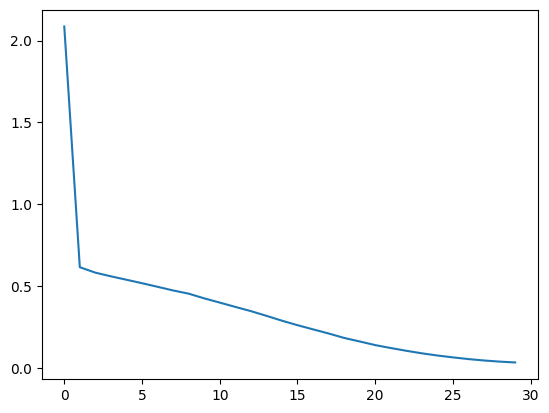

In [ ]:
plt.plot(loss_history)

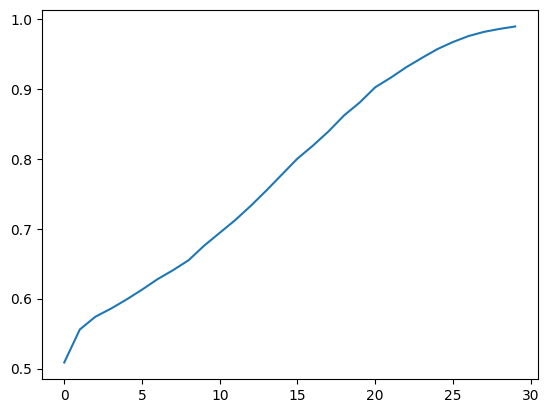

In [ ]:
plt.plot(train_acc_history)

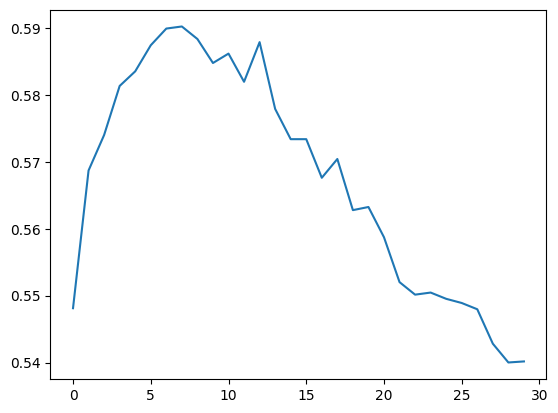

In [ ]:
plt.plot(test_acc_history)

In [ ]:
_ = [m.eval() for m in train_models]

In [ ]:
@torch.inference_mode()
def generate(hf_ds):
    gt_texts = [d['prompt'] for d in hf_ds['json']]
    tokenized_inputs = tokenize_text(gt_texts, generation_mode=True)
    images = [image.convert("RGB") for image in hf_ds['jpg']]
    images = [image_transforms(image) for image in images]
    image_embs = vision_encoder(torch.stack(images).to(device)).last_hidden_state

    text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
        input_ids=tokenized_inputs['input_ids'],
        attention_mask=tokenized_inputs['attention_mask'],
        llm_model=llm_model,
        vision_encoder=vision_encoder,
        pre_calc_image_emb=image_embs,
        vision_emb_compresser=image_emb_compressor,
        text_emb_projector=text_emb_projector,
        images=[],#tokenized_inputs['pixel_values'],
        image_token_id=IMAGE_TOKEN_ID,
        debug=False,
    )
    gen_tokens = llm_model.generate(inputs_embeds=text_vison_emb.to(llm_dtype), attention_mask=text_vison_mask, max_new_tokens=200)
    gen_texts = tokenizer.batch_decode(gen_tokens)
    return gen_texts

In [ ]:
test_samples = hf_dataset_sampled['test'].shuffle().select(range(6))[:]

In [ ]:
gt_texts = [d['prompt'] for d in test_samples['json']]

In [ ]:
test_samples.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'pixel_values', 'image_embs', 'input_ids', 'attention_mask', 'loss_target_pos_mask'])

In [ ]:
gen_texts = generate(test_samples)

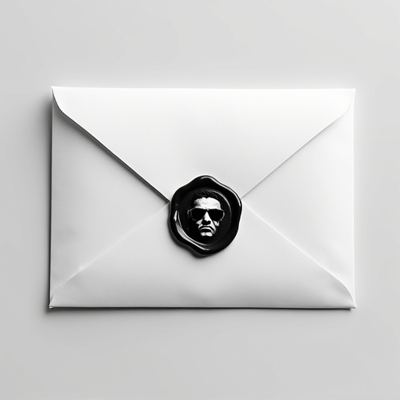

get_text :  A white ceramic mug with a black rim and a square base is displayed against a white background. The mug has a textured surface and the word 'Santi' written in black on the bottom right corner.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A white envelope with a black wax seal featuring a stylized image of a man's face with sunglasses, resembling a character from a movie or a graphic novel. The envelope is closed and the wax seal is centered on the front.


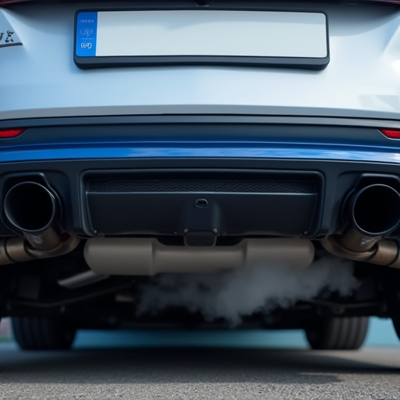

get_text :  A blue and white storage unit with a black logo on the top is parked on a concrete surface. The unit has a door with a white handle and is positioned in front of a red car with a widened license plate. The road has a green lane map in the background.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  The first image shows the underside of a car with a close-up view of the exhaust system. The exhaust pipes are emitting a visible plume of smoke, and the car's body is predominantly silver with some blue accents. The license plate is not visible, and the image has a watermark at the bottom left corner that reads 'SHUTTERSTOCK - 11143538'.


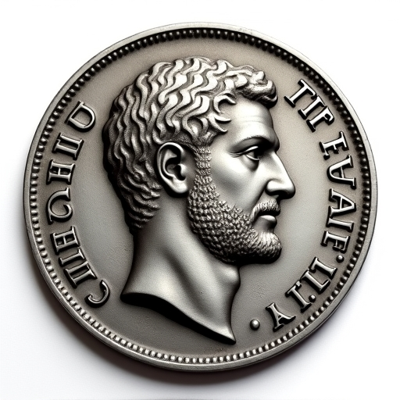

get_text :  A black and white photograph featuring a close-up of a t-shirt with a patterned fabric. The t-shirt has a large, decorative bow in the back and a short length. To the right, there is an inverted ballot with the text 'NOW OPEN' at the top and 'for criticism and suggestions' below it.<|im_end|>
gt_text :  A close-up image of a silver coin with a detailed portrait of a man on the obverse side. The coin has a textured surface and is set against a white background. The man's hair is styled in a way that suggests it might be curly, and he has a beard. The coin's inscription is in a foreign language, possibly Latin, and includes the words 'IMP CAESAR DIVI AVG F AVG' and 'TR POT'.


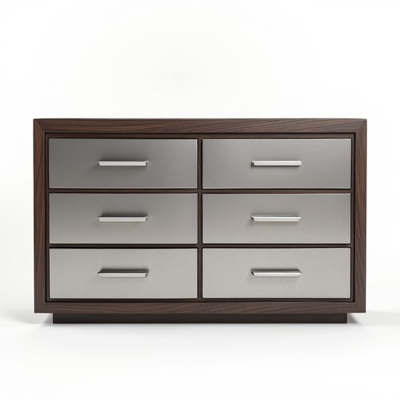

get_text :  A silver closed-bolt lock with a black handle and a rotisurator on the mechanism is displayed against a white background.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A modern, six-drawer dresser with a textured, metallic finish and a dark wood frame. The drawers have silver handles and are arranged in two rows of three. The dresser is set against a white background.


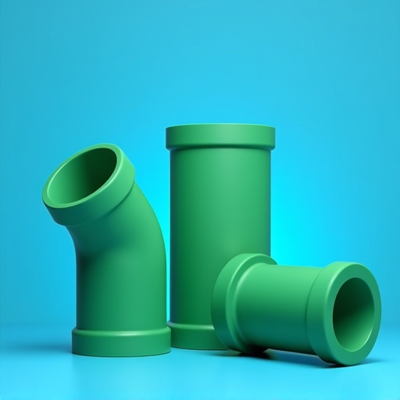

get_text :  A green glass bottle with a black cap is placed on a blue surface. The bottle contains achiote, a herb commonly used in skincare products. The surface has a textured appearance and the bottles are positioned in a way that they do not interfere with each other.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A set of three green rubber pipes is displayed on a blue surface. The pipes vary in size and shape, with the largest one on the left, a medium-sized one in the center, and the smallest one on the right. The largest pipe has a flared end, while the medium-sized pipe has a smooth, cylindrical shape. The smallest pipe has a flared end with a circular opening in the center.


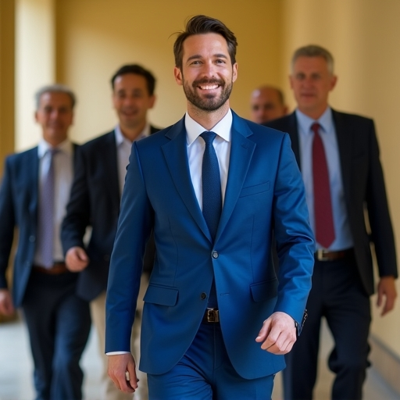

get_text :  A man in a blue shirt and black shoes is standing behind a stand of pink and white rhinced flowers. He is holding a spoon in his right hand and wearing gloves. The background shows a mannequin form with pink and white clothing.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A group of people, including a man in a blue suit and tie, are walking down a hallway. The man in the blue suit is in the center of the group, and he is smiling. There are other individuals in the group, some of whom are wearing ties. The hallway has a yellowish hue and is lined with columns.


In [ ]:
for img, gen_text, gt_text in zip(test_samples['jpg'], gen_texts, gt_texts):
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text : ', gt_text)
    print('='*70)

In [ ]:
train_samples = hf_dataset_sampled['train'].shuffle().select(range(6))[:]

In [ ]:
gt_texts = [d['prompt'] for d in train_samples['json']]

In [ ]:
gen_texts = generate(train_samples)

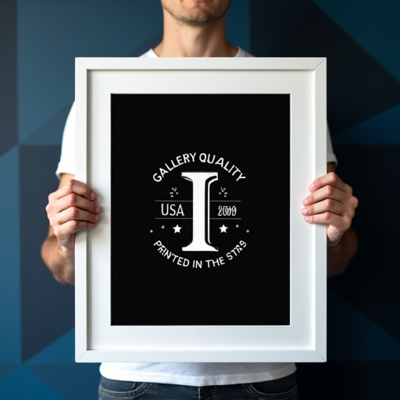

get_text :  A person is holding a framed picture with a black background and white text that reads 'How do you want to be treated?' followed by a author name 'J.D. Salinger' and a signature. The frame around the picture is dark. The person is standing in front of a room with a window, and the background is a plain light color.<|im_end|>
gt_text :  A person is holding a framed picture with a black background and a white graphic that reads 'Gallery Quality Printed in the USA 2009'. The graphic features a stylized letter 'I' with a star and a circle around it, and the text is surrounded by a decorative border. The frame is white, and the person is standing in front of a dark blue background with geometric shapes.


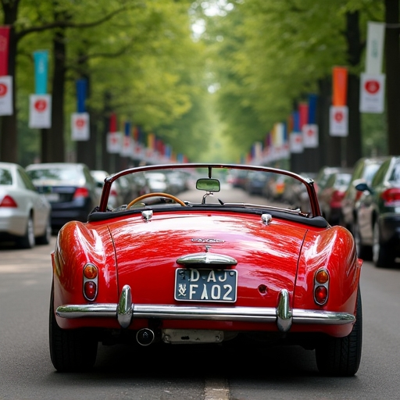

get_text :  A red convertible sports car is parked on a street lined with trees and flags. The car has a license plate that reads 'D-AJ 4231'. There are other cars parked in the background, and the scene appears to be in a park-like setting.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A red convertible sports car is parked on a street lined with trees and flags. The car has a license plate that reads 'D-AJ 4242'. There are other cars parked in the background, and the scene appears to be in a park-like setting.


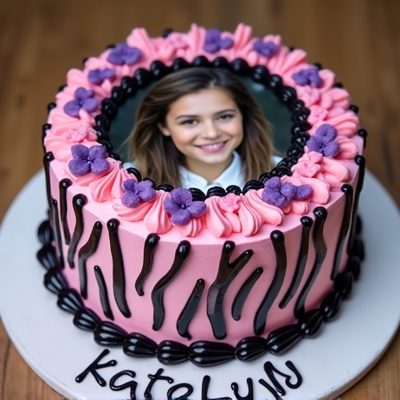

get_text :  A birthday cake with a zebra print design on the sides and a photo of a person in the center. The cake has a black border around the photo and is decorated with pink and purple icing. The name 'KATY' is written in cursive at the bottom of the cake.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A birthday cake with a zebra print design on the sides and a photo of a person in the center. The cake has a black border around the photo and is decorated with pink and purple icing. The name 'KATELYN' is written in cursive at the bottom of the cake.


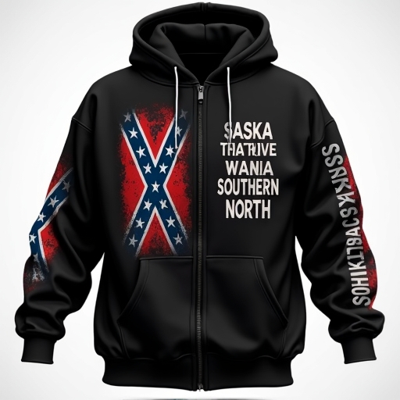

get_text :  A black hoodie with a graphic design featuring the Confederate flag on the left side and the text 'SASKATCHEWAN SOUTHERN NORTH' on the right side. The hoodie has a hood and a front zipper.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A black hoodie with a graphic design featuring the Confederate flag on the left side and the text 'SASKATCHEWAN SOUTHERN NORTH' on the right side. The hoodie has a hood and a front zipper.


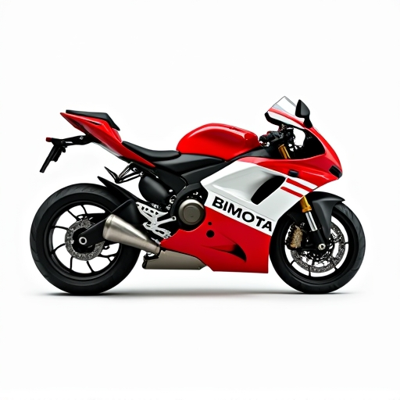

get_text :  A red and white motorcycle with the word 'BIMOTA' on the side is displayed against a white background. The motorcycle has a sleek design with a white front wheel and a red rear wheel, and its body is made of a metallic material. The tailgate is open, and the motorcycle appears to be parked on a sidewalk.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A red and white motorcycle with the word 'BIMOTA' on the side is displayed against a white background. The motorcycle has a sleek design with a white front fairing and a red rear section. The front wheel is on the left side, and the rear wheel is on the right side. The motorcycle has a black seat and a black exhaust pipe. The brand 'BIMOTA' is also visible on the front fairing.


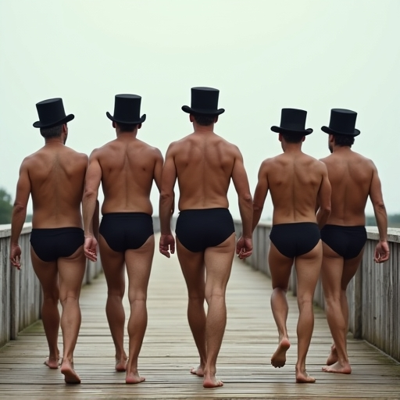

get_text :  A group of men wearing black top hats and black briefs are walking on a wooden pier. They are all barefoot and appear to be in a playful or humorous situation. The image has a caption at the bottom that reads 'NO ONE HAS A BAD TIME'.<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
gt_text :  A group of men wearing black top hats and black briefs are walking on a wooden pier. They are all barefoot and appear to be in a playful or humorous situation. The image has a caption at the bottom that reads 'NO ONE SIZE FITS ALL'.


In [ ]:
for img, gen_text, gt_text in zip(train_samples['jpg'], gen_texts, gt_texts):
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text : ', gt_text)
    print('='*70)

In [ ]:
def is_state_dict_identical(state_dict1, state_dict2):
    return all([(state_dict1[key] == state_dict2[key]).all() for key in state_dict1])

In [ ]:
is_state_dict_identical(vision_encoder.state_dict(), torch.load('init_vision_encoder.pt'))

False

In [ ]:
is_state_dict_identical(image_emb_compressor.state_dict(), torch.load('init_image_emb_compressor.pt'))

False

In [ ]:
is_state_dict_identical(llm_model.state_dict(), torch.load('init_llm_model.pt'))

False